# Performing a Sky Simulation with RFI Sources

This example shows how to include RFI into the simulation. We take an arbitrary sky and use karabo to simulate the visibilities and the interference due to satellites.

In [1]:
import os
from karabo.simulation.observation import Observation
from karabo.simulation.sky_model import SkyModel
from karabo.simulation.telescope import Telescope, VLAVersions
from karabo.simulation.interferometer import FilterUnits, InterferometerSimulation
from rascil.processing_components import create_visibility_from_ms
from karabo.simulator_backend import SimulatorBackend
from karabo.util.file_handler import FileHandler
from karabo.simulation.signal.rfi_signal import RFISignal

import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
from datetime import datetime, timedelta
from pathlib import Path

from karabo.imaging.imager_oskar import OskarDirtyImager, OskarDirtyImagerConfig
from karabo.imaging.imager_rascil import RascilDirtyImager, RascilDirtyImagerConfig
from karabo.imaging.imager_wsclean import WscleanDirtyImagerConfig, WscleanDirtyImager
from ska_sdp_datamodels.image import create_image

import matplotlib.pyplot as plt

%matplotlib inline

/home/andreas/miniconda3/envs/karabo-dev310/lib/python3.10/site-packages/ska_sdp_datamodels/configuration/config_create.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Parameter definition
ra_deg = 90
dec_deg = 34
start_time = datetime(2000, 3, 20, 6, 6, 39)
obs_length = timedelta(hours=0, minutes=15, seconds=0, milliseconds=0)
start_freq = 1.5e8
freq_bin = 1.0e7
number_of_time_steps = 5
number_of_channels = 2

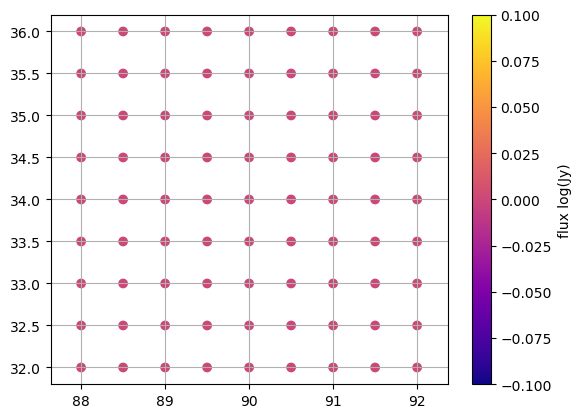

In [3]:
phasecenter = (ra_deg, dec_deg)
# Read in and plot the sky model
# sky = SkyModel.sky_test()

sky = SkyModel()
sky_data = np.zeros((81, SkyModel.SOURCES_COLS))
a = np.arange(phasecenter[0] - 2.0, phasecenter[0] + 2.5, 0.5)
b = np.arange(phasecenter[1] - 2.0, phasecenter[1] + 2.5, 0.5)
ra_arr, dec_arr = np.meshgrid(a, b)
sky_data[:, 0] = ra_arr.flatten()
sky_data[:, 1] = dec_arr.flatten()
sky_data[:, 2] = 1
sky.add_point_sources(sky_data)


# Sky Model if you want ONE POINT SOURCE ONLY
# sky = SkyModel()
# sky_data = np.array([[20.0, -30.0, 1]])
# sky.add_point_sources(sky_data)

sky.explore_sky(phase_center=phasecenter, wcs_enabled=False)

In [4]:
# Simulation settings that are the same for OSKAR and RASCIL
observation = Observation(
    phase_centre_ra_deg=ra_deg,
    phase_centre_dec_deg=dec_deg,
    start_date_and_time=start_time,
    length=obs_length,
    number_of_time_steps=number_of_time_steps,
    start_frequency_hz=start_freq,
    frequency_increment_hz=freq_bin,
    number_of_channels=number_of_channels,
)

# observation.compute_hour_angles_of_observation()

In [5]:
# `sim-vis` which is used for the RFI simulation relies on data from SpaceTrack service.
# It needs a login with username and password. Thus, we must provide the login as
# a .yaml file.
credentials_filename = "my_test_credentials.yaml"
f = open(credentials_filename, "w")
f.write("username: <add your username>\n")
f.write("password: <add ypur password>\n")
f.close()

In [6]:
# The class `RFISignal` controls the simulation of RFI sources
rfi_simulation = RFISignal()
rfi_simulation.set_credentials_filename(credentials_filename)

Creating /tmp/karabo-STM-andreas-4S0i7QquzI/tabsim-files-KYAyH124na for working directory for sim-vis


In [7]:
simulation = InterferometerSimulation(
    channel_bandwidth_hz=1.0e7,
    time_average_sec=8,
    ignore_w_components=True,
    uv_filter_units=FilterUnits.Metres,
    use_gpus=False,
    use_dask=False,
    station_type="Isotropic beam",  # This is only used by OSKAR (beam setting in OSKAR)
)

In [8]:
output_base_directory = Path(
    FileHandler().get_tmp_dir(
        prefix="line-emission-",
        purpose="Example line emission simulation",
    )
)

Creating /tmp/karabo-STM-andreas-4S0i7QquzI/line-emission-U5FZ14oWPd for Example line emission simulation


In [9]:
#### OSKAR SIMULATION
# Load the telescope (SKA-Mid)
telescope = Telescope.constructor("VLA", VLAVersions.D, backend=SimulatorBackend.OSKAR)

visibility = simulation.run_simulation(
    telescope=telescope,
    sky=sky,
    observation=observation,
    backend=SimulatorBackend.OSKAR,
    primary_beam=None,
    visibility_format="MS",
    visibility_path=os.path.join(output_base_directory, "OSKAR.MS"),
    # rfi_signals=rfi_simulation,
)

Matched path /tmp/karabo-STM-andreas-4S0i7QquzI/line-emission-U5FZ14oWPd/OSKAR.MS to format MS
Saved visibility to /tmp/karabo-STM-andreas-4S0i7QquzI/line-emission-U5FZ14oWPd/OSKAR.MS
Matched path /tmp/karabo-STM-andreas-4S0i7QquzI/line-emission-U5FZ14oWPd/OSKAR.MS to format MS


In [10]:
visibility.path

'/tmp/karabo-STM-andreas-4S0i7QquzI/line-emission-U5FZ14oWPd/OSKAR.MS'

In [11]:
# Set Imaging parameters
fov = 30 / 180 * np.pi
imaging_cellsize = (1.2 / 60) / 180 * np.pi
imaging_npixel = int(fov / imaging_cellsize)
imaging_npixel = imaging_npixel if imaging_npixel % 2 == 0 else imaging_npixel + 1
print(f"Image size of : {imaging_npixel}")

dirty_imager_config = WscleanDirtyImagerConfig(
    imaging_npixel=imaging_npixel,
    imaging_cellsize=imaging_cellsize,
    intervals_out=number_of_time_steps,
)

dirty_imager = WscleanDirtyImager(dirty_imager_config)
# Imaging with WSClean
dirty_ws_list = dirty_imager.create_dirty_image_series(visibility)
dirty_ws_list

Image size of : 1500
Creating /tmp/karabo-STM-andreas-4S0i7QquzI/WSClean-dirty-xAXgZoJzna for Disk cache for WSClean dirty images
WSClean command: cd /tmp/karabo-STM-andreas-4S0i7QquzI/WSClean-dirty-xAXgZoJzna && OPENBLAS_NUM_THREADS=1 wsclean -size 1500 1500 -scale 0.02deg -intervals-out 5 /tmp/karabo-STM-andreas-4S0i7QquzI/line-emission-U5FZ14oWPd/OSKAR.MS
WSClean output:
[
WSClean version 3.5 (2024-07-30)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  145-165 (2)
Counting number of scans... DONE (5)
Precalculating weights for uniform weighting...
Opening /tmp/karabo-STM-andreas-4S0i7QquzI/line-emission-U5FZ14oWPd/OSKAR.MS, spw 0 with contiguous MS reader.
Mapping measurement set rows... DONE (0-351; 351 rows)
 == Constructing i

['/tmp/karabo-STM-andreas-4S0i7QquzI/WSClean-dirty-xAXgZoJzna/wsclean-t0000-dirty.fits',
 '/tmp/karabo-STM-andreas-4S0i7QquzI/WSClean-dirty-xAXgZoJzna/wsclean-t0001-dirty.fits',
 '/tmp/karabo-STM-andreas-4S0i7QquzI/WSClean-dirty-xAXgZoJzna/wsclean-t0002-dirty.fits',
 '/tmp/karabo-STM-andreas-4S0i7QquzI/WSClean-dirty-xAXgZoJzna/wsclean-t0003-dirty.fits',
 '/tmp/karabo-STM-andreas-4S0i7QquzI/WSClean-dirty-xAXgZoJzna/wsclean-t0004-dirty.fits']

In [12]:
dirty_ws_list

['/tmp/karabo-STM-andreas-4S0i7QquzI/WSClean-dirty-xAXgZoJzna/wsclean-t0000-dirty.fits',
 '/tmp/karabo-STM-andreas-4S0i7QquzI/WSClean-dirty-xAXgZoJzna/wsclean-t0001-dirty.fits',
 '/tmp/karabo-STM-andreas-4S0i7QquzI/WSClean-dirty-xAXgZoJzna/wsclean-t0002-dirty.fits',
 '/tmp/karabo-STM-andreas-4S0i7QquzI/WSClean-dirty-xAXgZoJzna/wsclean-t0003-dirty.fits',
 '/tmp/karabo-STM-andreas-4S0i7QquzI/WSClean-dirty-xAXgZoJzna/wsclean-t0004-dirty.fits']